https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
https://www.kaggle.com/kvpratama/pokemon-images-dataset
https://www.jeremyjordan.me/autoencoders/
https://blog.keras.io/building-autoencoders-in-keras.html
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

# Pokemon Images Autoencoder and GAN
In this project, I experiment with creating autoencoders using dense layers and convolutional / pooling layers. Then I use the autoencoder in order to remove gaussian noise from images. After that, I build and train a GAN. 

In [1]:
import tensorflow as tf
import numpy as np
import os

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import itertools
from tensorflow import keras

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.version.VERSION
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Importing the data as an array
First, I set up the base directory and find the number of pictures that I have. Then I iterate through all of the images, open them, resize them to be 64x64x3, divide the pixel density by 255 so every pixel is in the range of 0:1, add them to an array of arrays, and then split into the training and test set.

In [8]:
base_dir = os.path.join(os.getcwd(), os.pardir, "pokemon_jpg")
pokemon_pictures = os.listdir(os.path.join(base_dir, "pokemon_jpg"))
print(pokemon_pictures[:10])

['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg', '107.jpg']


In [6]:
print("Dataset contains " + str(len(pokemon_pictures)) + " pictures")

Dataset contains 819 pictures


In [32]:
from PIL import ImageOps, Image
size = 64, 64

for f in os.listdir(os.path.join(base_dir, "pokemon_jpg")):
    im = Image.open(os.path.join(base_dir, "pokemon_jpg", f)).resize(size, Image.ANTIALIAS)
    break

big_arr = np.array([np.array(im)]).reshape(1, 64, 64, 3)
for f in os.listdir(os.path.join(base_dir,"pokemon_jpg"))[1:]:
    big_arr = np.append(big_arr, [np.array(Image.open(os.path.join(base_dir, "pokemon_jpg", f)).resize(size, Image.ANTIALIAS)).reshape(64, 64, 3)], axis=0)
    #i+=1
    
big_arr = big_arr/255

full array shape: (819, 64, 64, 3)
train shape: (600, 64, 64, 3)
test shape: (200, 64, 64, 3)

Example Image: 


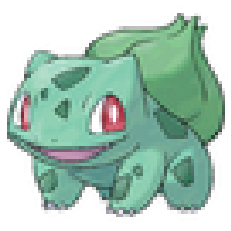

In [33]:
x_train = big_arr[:600]
x_test = big_arr[600:800]
print("full array shape: " + str(big_arr.shape))
print("train shape: " + str(x_train.shape))
print("test shape: " + str(x_test.shape) + "\n")

print("Example Image: ")
plt.imshow(big_arr[0])
plt.axis('off')
plt.show()

Flattening the arrays so that each image is represented as a continuous stream of numbers.

In [54]:
big_arr3 = big_arr.reshape((len(big_arr), np.prod(big_arr.shape[1:])))
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print("full array shape: " + str(big_arr3.shape))
print("x_train shape: " + str(x_train.shape))
print("x_test shape: " + str(x_test.shape))

full array shape: (819, 12288)
x_train shape: (600, 12288)
x_test shape: (200, 12288)



# Creating a supervised learning problem out of an unlabeled dataset
I can take an unlabeled dataset and frame it as a supervised learning problem tasked with outputting x, a reconstruction of the original input x. This network can be trained by minimizing the reconstruction error, L(x, x^), which measures the differences between the original input and the consequent reconstruction. A bottleneck constrains the amount of information that can traverse the full network, forcing a learned compression of the input data. In this case the image, which contains 12288 is fed through a bottleneck which contains only 32 neurons. Then it is reconstructed back to its original size

For this first autoencoder, I'm using a series of dense layers to encode and decode the images.

In [38]:
from tensorflow.keras import regularizers
input_shape = 64*64*3
#encoding_dim = 100

input_img = keras.Input(shape=(input_shape,))
encoded = keras.layers.Dense(64, activation='relu')(input_img)
encoded = keras.layers.Dense(32, activation='relu')(encoded)

decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded2 = keras.layers.Dense(input_shape, activation='sigmoid')(decoded)

# model which maps input with reconstruction
autoencoder = keras.Model(input_img, decoded2)

In [39]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12288)]           0         
_________________________________________________________________
dense (Dense)                (None, 64)                786496    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 12288)             798720    
Total params: 1,589,408
Trainable params: 1,589,408
Non-trainable params: 0
_________________________________________________________________


 separate encoder model
#encoder = keras.Model(input_img, encoded)

#decoder model
#encoded_input = keras.Input(shape=(32,))
#retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-2:]
#create the decoder model
#decoder = keras.Model(encoded_input, decoded, decoded2)
#autoencoder = keras.Model(input_img, decoded)

#decoder_layer

Next, I'm going to fit the model. The input is x_train and the output is also x_train since the goal is for the autoencoder to encode the images, feed them through a bottleneck, and then decode them to be as close as possible to the original image.

In [44]:
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=10, shuffle=True, validation_data=(x_test, x_test), verbose=10)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Feed the test images, which have never been seen before, through the autoencoder.

In [48]:
decoded_imgs = autoencoder.predict(x_test)
decoded_imgs.shape

(200, 12288)

Below, I can see the original images compared with the images fed through the autoencoder. The images are fuzzy and some of the color has been removed, but the autoencoder is able to pick up on the main features. 

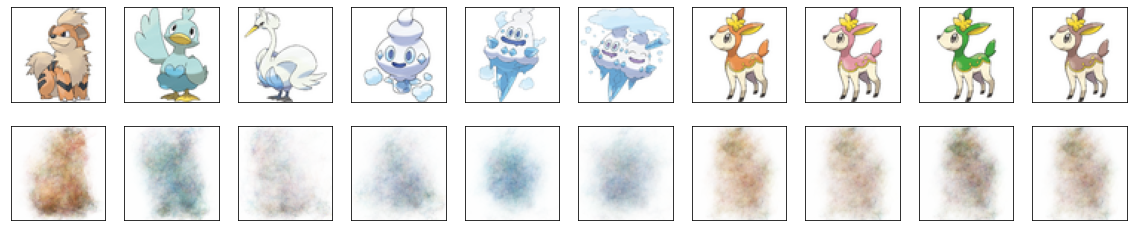

In [49]:
import matplotlib.pyplot as plt

n = 10  # How many pictures we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional Autoencoder
Next, I'm going to test how a convolutional autoencoder will perform. I feed the original image through two Conv2D/MaxPooling2D layers in order to encode the image down to 32 neurons. Then I use two Conv2D/UpSampling2D layers to decode the image back to its original size. I'm setting the input shape as (64, 64, 3), so I will need to reshape my x_train and x_test back to a shape of (64, 64, 3).

In [55]:
input_img = tf.keras.Input(shape=(64, 64, 3))

x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [56]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 8)         0   

In [63]:
x_train = big_arr[:600]
x_test = big_arr[600:800]

print("x_train shape: " + str(x_train.shape))
print("x_test shape: " + str(x_test.shape))

x_train shape: (600, 64, 64, 3)
x_test shape: (200, 64, 64, 3)


In order to compare different runs, I'm going to use tensorboard and the tensorboard_callback.

In [60]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

In [61]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [62]:
autoencoder.fit(x_train, x_train,
               epochs=50,
               batch_size=128,
               shuffle=True,
               validation_data=(x_test, x_test),
               callbacks=[tensorboard_callback])

Epoch 1/50
5/5 [==============================] - 6s 193ms/step - loss: 0.6862 - val_loss: 0.6545
Epoch 2/50
5/5 [==============================] - 0s 29ms/step - loss: 0.6428 - val_loss: 0.5767
Epoch 3/50
5/5 [==============================] - 0s 30ms/step - loss: 0.5614 - val_loss: 0.4868
Epoch 4/50
5/5 [==============================] - 0s 28ms/step - loss: 0.5001 - val_loss: 0.4799
Epoch 5/50
5/5 [==============================] - 0s 28ms/step - loss: 0.4906 - val_loss: 0.4510
Epoch 6/50
5/5 [==============================] - 0s 28ms/step - loss: 0.4640 - val_loss: 0.4472
Epoch 7/50
5/5 [==============================] - 0s 28ms/step - loss: 0.4590 - val_loss: 0.4367
Epoch 8/50
5/5 [==============================] - 0s 28ms/step - loss: 0.4506 - val_loss: 0.4269
Epoch 9/50
5/5 [==============================] - 0s 28ms/step - loss: 0.4372 - val_loss: 0.4165
Epoch 10/50
5/5 [==============================] - 0s 28ms/step - loss: 0.4257 - val_loss: 0.4011
Epoch 11/50
5/5 [===========

In [65]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 10124), started 16 days, 0:52:48 ago. (Use '!kill 10124' to kill it.)

In [66]:
decoded_imgs = autoencoder.predict(x_test)

Below, I can see the original images compared with the images fed through the autoencoder. The images are more fuzzy and some of the color has been removed, but the autoencoder is able to pick up on the main features. The convolutional autoencoder seems to be performing much better than the standard DNN autoencoder.

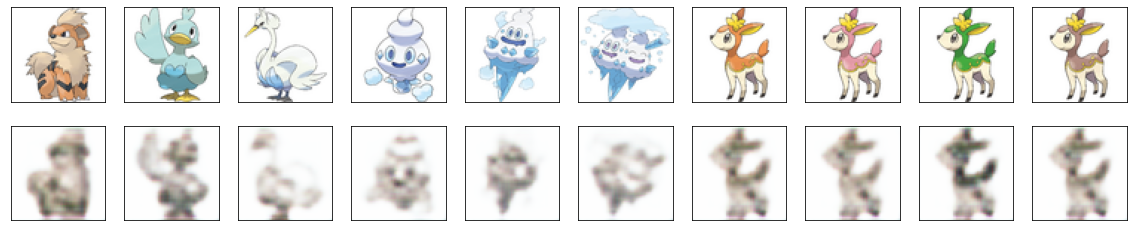

In [67]:
import matplotlib.pyplot as plt

n = 10  # How many pictures to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Application to image denoising
Since the aim of an autoencoder is to learn a representation for a set of data, the autoencoder needs to focus on the main features of the data. Therefore, autoencoders are good at removing noise from images. Below, I'm going to create a dataset of images with gaussian noise. Then I'm going to feed those images through a convolutional autoencoder to train it. Finally, I'm going to test how well the autoencoder performed. 

In [70]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

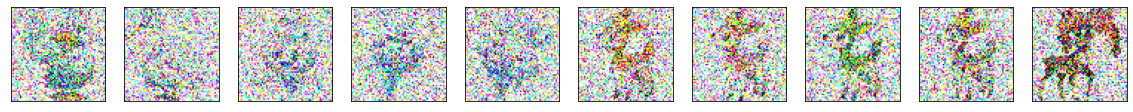

In [71]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In order to improve the quality of the reconstructed, I'm going to use a slightly different model with more filters per layer


In [72]:
input_img = tf.keras.Input(shape=(64, 64, 3))

x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [73]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 32, 32, 32)        0   

In [74]:
autoencoder.fit(x_train_noisy, x_train,
               epochs=50,
               batch_size=128,
               shuffle=True,
               validation_data=(x_test_noisy, x_test),
               callbacks=[tensorboard_callback])

Epoch 1/50
5/5 [==============================] - 2s 331ms/step - loss: 0.6740 - val_loss: 0.5276
Epoch 2/50
5/5 [==============================] - 0s 33ms/step - loss: 0.5206 - val_loss: 0.4887
Epoch 3/50
5/5 [==============================] - 0s 32ms/step - loss: 0.4950 - val_loss: 0.4700
Epoch 4/50
5/5 [==============================] - 0s 32ms/step - loss: 0.4797 - val_loss: 0.4448
Epoch 5/50
5/5 [==============================] - 0s 32ms/step - loss: 0.4559 - val_loss: 0.4299
Epoch 6/50
5/5 [==============================] - 0s 32ms/step - loss: 0.4441 - val_loss: 0.4073
Epoch 7/50
5/5 [==============================] - 0s 33ms/step - loss: 0.4192 - val_loss: 0.3786
Epoch 8/50
5/5 [==============================] - 0s 32ms/step - loss: 0.3900 - val_loss: 0.3519
Epoch 9/50
5/5 [==============================] - 0s 32ms/step - loss: 0.3648 - val_loss: 0.3315
Epoch 10/50
5/5 [==============================] - 0s 32ms/step - loss: 0.3483 - val_loss: 0.3234
Epoch 11/50
5/5 [===========

In [75]:
decoded_imgs = autoencoder.predict(x_test_noisy)

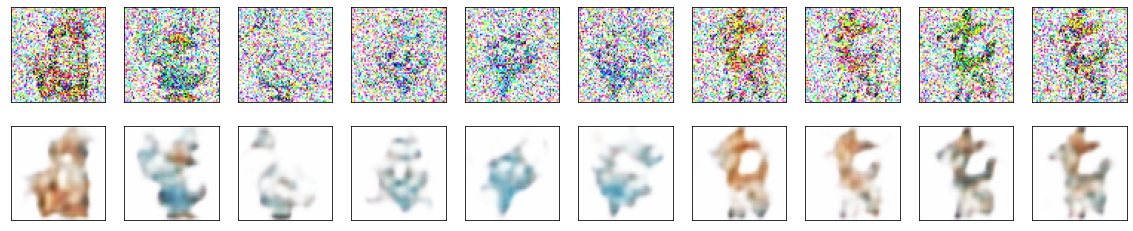

In [76]:
n = 10  # How many pictures to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# GANs
A Generative Adversarial Network (GAN) is an algorithmic architecture that uses two neural networks, putting one against the other in order to generate new, synthetic instances of data that can pass for real data. One neural network, called the generator, generates new data instances. The other neural network, called the discriminator, evaluates them for authenticity.

## Convert arrays to black and white
Because I'm working with such a small dataset, I'm going to convert the images to black and white and try to create a GAN based on the black and white images. 

In [98]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [117]:
x_train = big_arr[:600]
x_test = big_arr[600:800]

x_train = rgb2gray(x_train)
x_test = rgb2gray(x_test)

x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

print("x_train shape: " + str(x_train.shape))
print("x_test shape: " + str(x_test.shape))

x_train shape: (600, 64, 64, 1)
x_test shape: (200, 64, 64, 1)


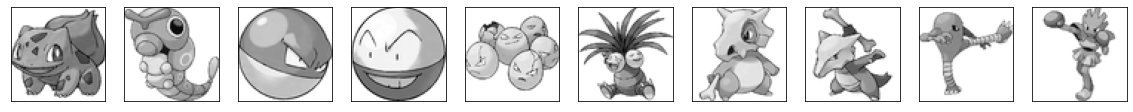

In [118]:
n = 10  # How many pictures we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Define and Train the Discriminator Model
First, I'm going to create a neural network that can discriminate between the real images and the fake images. This will take the (64, 64, 3) images and feed them through a neural network. I'm going to use convolutions because they perform better. Also, I'm going to use dropout for regularization. This is a binary classification task, so the output layer will be composed of a single neuron with a sigmoid activation function.

In [119]:
def define_discriminator(in_shape=(64, 64, 1)):
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # compile model
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [120]:
model = define_discriminator()

In [121]:
# the aggressive 2x2 stride acts to down-sample the input image, first from 64x64 to 32x32, then to 16x16 before the model makes
# the output prediction
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)            

## Create generator to generate real samples
Now I'm going to write a function that will take the training dataset as an argument and will select a random subsample of images. It will also return class labels for the sample, specifically a class label of 1, to indicate real images.

In [122]:
#from random import Random as random
import random
def generate_real_samples(dataset, n_samples):
    rand_selection = []
    for i in range(n_samples):
        rand_selection.append(random.randint(0, dataset.shape[0]-1))
    X = dataset[rand_selection]
    y = np.ones((n_samples, 1))
    return X, y

In [123]:
real_samples_to_generate = 128
test_x_train, test_y_train = generate_real_samples(x_train, real_samples_to_generate)

print("test_x_train shape: " + str(test_x_train.shape))
print("test_y_train shape: " + str(test_y_train.shape))

test_x_train shape: (128, 64, 64, 1)
test_y_train shape: (128, 1)


## Create generator to generate fake samples
Next, I want to write a function that will generate fake samples. These fake samples will be created 

In [127]:
# next, I want to be able to generate fake samples with images comprised of random pixel values
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = np.random.rand(64 * 64 * n_samples)
    # reshape into a batch of images
    X = X.reshape((n_samples, 64, 64, 1))
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [128]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch = 200):
    half_batch = int(n_batch/2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(x_train, half_batch)
        # update the discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [129]:
train_discriminator(model, x_train)

>1 real=100% fake=0%
>2 real=100% fake=0%
>3 real=100% fake=0%
>4 real=100% fake=0%
>5 real=100% fake=0%
>6 real=100% fake=0%
>7 real=100% fake=0%
>8 real=100% fake=0%
>9 real=100% fake=0%
>10 real=100% fake=0%
>11 real=100% fake=0%
>12 real=100% fake=0%
>13 real=100% fake=0%
>14 real=100% fake=1%
>15 real=100% fake=0%
>16 real=100% fake=0%
>17 real=100% fake=0%
>18 real=100% fake=6%
>19 real=100% fake=9%
>20 real=100% fake=13%
>21 real=100% fake=30%
>22 real=100% fake=55%
>23 real=100% fake=70%
>24 real=100% fake=85%
>25 real=100% fake=94%
>26 real=100% fake=100%
>27 real=100% fake=100%
>28 real=100% fake=100%
>29 real=100% fake=100%
>30 real=100% fake=100%
>31 real=100% fake=100%
>32 real=100% fake=100%
>33 real=100% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fake=10

The generator model is responsible for creating new, fake but plausible images by taking a point from the latent space as input and outputting a square grayscale image. The latent space is an arbitrarily defined vector space of Gaussian-distributed values. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points until, at the end of training, the latent vector space represents a compressed representation of the output space of pokemon images that only the generator knows how to turn into plausible pokemon images.

The generator model is not compiled and does not specify a loss function or optimization algorithm. This is because the generator is not trained directly.

In [130]:
# define the standalone generator model
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
def define_generator(latent_dim):
    model = tf.keras.Sequential()
    # foundation for the 16x16 image
    n_nodes = 128 * 16 * 16
    model.add(tf.keras.layers.Dense(n_nodes, input_dim = latent_dim))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((16, 16, 128)))
    # upsample to 32x32
    # with a Conv2DTranspose layer, it is good practice to use a kernel size that is a factor of the stride (double)
    # to avoid a checkerboard pattern that can be observed when upsampling
    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # the output layer is a Conv2D with 1 filters and a kernel size of 7x7 and 'same' padding, designed to create a
    # 1 feature map and preserve its dimensions at 64x64 pixels
    # a sigmoid activation is used to ensure output values are in the desired range of [0,1]
    model.add(tf.keras.layers.Conv2D(1, (7, 7), activation='sigmoid', padding='same'))
    return model

In [131]:
latent_dim = 100
model = define_generator(latent_dim)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 64, 128)      

In [132]:
#from tf.keras.utils.vis_utils import plot_model
#tf.keras.utils.plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

The first step is to generate new points in the latent space. This can be done by calling np.randn() for generating arrays of random numbers drawn from a standard Gaussian. The array of random numbers can then be reshaped into samples, which is n rows with 100 elements per row. I will do this with the generate_latent_points() function

In [133]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

Next, I will define a generate_fake_samples() function that returns both the generated samples and the associated class labels

In [134]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    # create 'fake' class labels
    y = np.zeros((n_samples, 1))
    return X, y

I can then plot the generated samples by calling the imshow() function. Since the model is not trained, the generated images are complately random pixel values

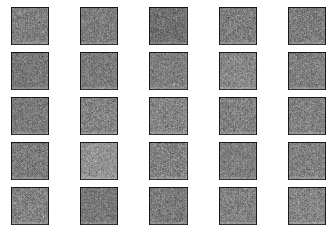

In [136]:
#import pyplot as plt
# size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# generate the samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64, 1))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Training the Generator Model
The weights in the generator model are updated based on the performance of the discriminator model. When the discriminator model is good at detecting fake samples, teh generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

I'm going to do this by creating a new model that combines the generator and discriminator models. I'll do this by stacking the generator and discriminator so that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly and then are classified and the output of this larger model can be used to update the model weights of the generator.

The discriminator is only concerned with distinguishing between real and fake samples, so it can be trained in a standalone manner on examples of each.

The generator model is only concerned with the discriminator's performance on fake samples. Therefore, I will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator in this GAN model, I want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, I will mark the generated samples as real (class 1)

In [138]:
# define the combined generator and dscriminator model for updating the generator
def define_gan(g_model, d_model):
    # make weight in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = tf.keras.Sequential()
    model.add(g_model)
    model.add(d_model)
    # I'm going to add an Adam optimizer with lr of 0.0002 and momentum of 0.5, which is recommended
    # when training deep convolutional GANs
    opt = tf.keras.optimizers.Adam(lr = 0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [139]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

Here, I can see the model expects the pokemon images as input and predicts a single value as output

In [140]:
# summarize gan model
gan_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 64, 64, 1)         3840385   
_________________________________________________________________
sequential_8 (Sequential)    (None, 1)                 53953     
Total params: 3,894,338
Trainable params: 3,840,385
Non-trainable params: 53,953
_________________________________________________________________


In [141]:
# train the composite model
# the number of batches within an epoch is defined by how many times the batch size divides into the training set
# Since I have a dataset size of 600 samples and batch_size  of 200, there are 3 batches per epoch
def train_gan(gan_model, latent_dim, n_epochs=30, n_batch=3):
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

## Evaluating GAN Model Performance
Currently, there are no objective ways to evaluate the performance of a GAN model, so the images must be subjectively evaluated for quality by a human operator. So, I cannot know when to stop training without looking at examples of generated images. Due to the adversarial nature of the training process, the generator is changing after every batch. So once "good enough" images can be generated, the subjective quality of the images may then begin to vary, improve, or degrade with subsequent updates.

In order to handle this complex training situation, I will:
- periodically evaluate the classification accuracy of the discriminator on real and fake images
- periodically generate many images and save them for subjective review
- periodically save the generator model

In [142]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate disciminator on real samples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

First, I will update the discriminator model with real and fake samples, then update the generator via the composite model. I'll be doing this via the train_discriminator() function and then the train_gan() function.

The discriminator model is updated once per batch by combining one half of a batch of fake and real examples into a single batch.

Finally, I will report the loss each batch so I can keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating bad examples that the discriminator can easily discriminate.

In [143]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30, n_batch=3):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate fake examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
            # evaluate model performance, somtimes
            if (i+1) % 10 == 0:
                summarize_performance(i , g_model, d_model, dataset, latent_dim)

Below, I can see that in this case, the loss remains stable over the course of training

In [144]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
#dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, x_train, latent_dim)

>1, 1200, d=0.640, g=0.714
>1, 2200, d=0.695, g=0.690
>1, 3200, d=0.652, g=0.704
>1, 4200, d=0.701, g=0.650
>1, 5200, d=0.636, g=0.674
>1, 6200, d=0.722, g=0.638
>1, 7200, d=0.659, g=0.655
>1, 8200, d=0.599, g=0.602
>1, 9200, d=0.745, g=0.608
>1, 10200, d=0.667, g=0.604
>1, 11200, d=0.634, g=0.591
>1, 12200, d=0.647, g=0.567
>1, 13200, d=0.701, g=0.581
>1, 14200, d=0.678, g=0.586
>1, 15200, d=0.656, g=0.550
>1, 16200, d=0.590, g=0.533
>1, 17200, d=0.725, g=0.553
>1, 18200, d=0.626, g=0.498
>1, 19200, d=0.665, g=0.562
>1, 20200, d=0.659, g=0.498
>1, 21200, d=0.755, g=0.565
>1, 22200, d=0.682, g=0.552
>1, 23200, d=0.628, g=0.559
>1, 24200, d=0.705, g=0.691
>1, 25200, d=0.673, g=0.686
>1, 26200, d=0.610, g=0.696
>1, 27200, d=0.736, g=0.709
>1, 28200, d=0.582, g=0.775
>1, 29200, d=0.615, g=0.825
>1, 30200, d=0.746, g=0.837
>1, 31200, d=0.625, g=0.831
>1, 32200, d=0.674, g=0.737
>1, 33200, d=0.753, g=0.702
>1, 34200, d=0.622, g=0.665
>1, 35200, d=0.722, g=0.691
>1, 36200, d=0.689, g=0.840
>

>2, 65200, d=0.697, g=0.661
>2, 66200, d=0.776, g=0.602
>2, 67200, d=0.714, g=0.649
>2, 68200, d=0.637, g=0.694
>2, 69200, d=0.677, g=0.620
>2, 70200, d=0.733, g=0.601
>2, 71200, d=0.672, g=0.622
>2, 72200, d=0.621, g=0.619
>2, 73200, d=0.713, g=0.661
>2, 74200, d=0.745, g=0.689
>2, 75200, d=0.681, g=0.658
>2, 76200, d=0.734, g=0.641
>2, 77200, d=0.699, g=0.616
>2, 78200, d=0.749, g=0.680
>2, 79200, d=0.630, g=0.696
>2, 80200, d=0.668, g=0.677
>2, 81200, d=0.714, g=0.608
>2, 82200, d=0.690, g=0.634
>2, 83200, d=0.606, g=0.681
>2, 84200, d=0.722, g=0.676
>2, 85200, d=0.666, g=0.724
>2, 86200, d=0.752, g=0.725
>2, 87200, d=0.665, g=0.670
>2, 88200, d=0.781, g=0.698
>2, 89200, d=0.716, g=0.822
>2, 90200, d=0.689, g=0.719
>2, 91200, d=0.723, g=0.630
>2, 92200, d=0.701, g=0.734
>2, 93200, d=0.693, g=0.724
>2, 94200, d=0.721, g=0.671
>2, 95200, d=0.686, g=0.681
>2, 96200, d=0.670, g=0.618
>2, 97200, d=0.682, g=0.644
>2, 98200, d=0.806, g=0.561
>2, 99200, d=0.714, g=0.683
>2, 100200, d=0.706,

>3, 157200, d=0.596, g=0.622
>3, 158200, d=0.621, g=0.625
>3, 159200, d=0.712, g=0.643
>3, 160200, d=0.724, g=0.579
>3, 161200, d=0.734, g=0.565
>3, 162200, d=0.685, g=0.608
>3, 163200, d=0.705, g=0.581
>3, 164200, d=0.706, g=0.592
>3, 165200, d=0.753, g=0.646
>3, 166200, d=0.687, g=0.659
>3, 167200, d=0.651, g=0.664
>3, 168200, d=0.772, g=0.669
>3, 169200, d=0.780, g=0.621
>3, 170200, d=0.726, g=0.636
>3, 171200, d=0.703, g=0.664
>3, 172200, d=0.720, g=0.728
>3, 173200, d=0.801, g=0.589
>3, 174200, d=0.708, g=0.758
>3, 175200, d=0.700, g=0.720
>3, 176200, d=0.729, g=0.688
>3, 177200, d=0.756, g=0.657
>3, 178200, d=0.660, g=0.672
>3, 179200, d=0.692, g=0.706
>3, 180200, d=0.736, g=0.654
>3, 181200, d=0.711, g=0.687
>3, 182200, d=0.768, g=0.682
>3, 183200, d=0.678, g=0.673
>3, 184200, d=0.659, g=0.671
>3, 185200, d=0.771, g=0.659
>3, 186200, d=0.698, g=0.609
>3, 187200, d=0.721, g=0.653
>3, 188200, d=0.784, g=0.641
>3, 189200, d=0.659, g=0.592
>3, 190200, d=0.683, g=0.739
>3, 191200, d=

>5, 50200, d=0.707, g=0.669
>5, 51200, d=0.750, g=0.676
>5, 52200, d=0.710, g=0.669
>5, 53200, d=0.712, g=0.747
>5, 54200, d=0.710, g=0.736
>5, 55200, d=0.737, g=0.685
>5, 56200, d=0.684, g=0.681
>5, 57200, d=0.668, g=0.682
>5, 58200, d=0.712, g=0.731
>5, 59200, d=0.724, g=0.748
>5, 60200, d=0.724, g=0.710
>5, 61200, d=0.662, g=0.683
>5, 62200, d=0.717, g=0.678
>5, 63200, d=0.670, g=0.671
>5, 64200, d=0.718, g=0.645
>5, 65200, d=0.778, g=0.638
>5, 66200, d=0.769, g=0.612
>5, 67200, d=0.712, g=0.652
>5, 68200, d=0.754, g=0.643
>5, 69200, d=0.725, g=0.656
>5, 70200, d=0.764, g=0.648
>5, 71200, d=0.664, g=0.709
>5, 72200, d=0.756, g=0.666
>5, 73200, d=0.683, g=0.707
>5, 74200, d=0.713, g=0.736
>5, 75200, d=0.697, g=0.726
>5, 76200, d=0.717, g=0.745
>5, 77200, d=0.710, g=0.755
>5, 78200, d=0.687, g=0.721
>5, 79200, d=0.693, g=0.717
>5, 80200, d=0.699, g=0.724
>5, 81200, d=0.720, g=0.711
>5, 82200, d=0.741, g=0.693
>5, 83200, d=0.701, g=0.701
>5, 84200, d=0.709, g=0.679
>5, 85200, d=0.643, 

>6, 141200, d=0.693, g=0.703
>6, 142200, d=0.671, g=0.670
>6, 143200, d=0.690, g=0.677
>6, 144200, d=0.701, g=0.674
>6, 145200, d=0.675, g=0.695
>6, 146200, d=0.714, g=0.672
>6, 147200, d=0.697, g=0.667
>6, 148200, d=0.694, g=0.663
>6, 149200, d=0.725, g=0.648
>6, 150200, d=0.713, g=0.654
>6, 151200, d=0.655, g=0.694
>6, 152200, d=0.698, g=0.692
>6, 153200, d=0.701, g=0.687
>6, 154200, d=0.728, g=0.696
>6, 155200, d=0.685, g=0.700
>6, 156200, d=0.702, g=0.638
>6, 157200, d=0.694, g=0.662
>6, 158200, d=0.710, g=0.629
>6, 159200, d=0.692, g=0.710
>6, 160200, d=0.697, g=0.682
>6, 161200, d=0.712, g=0.694
>6, 162200, d=0.708, g=0.683
>6, 163200, d=0.699, g=0.677
>6, 164200, d=0.660, g=0.733
>6, 165200, d=0.690, g=0.732
>6, 166200, d=0.678, g=0.746
>6, 167200, d=0.714, g=0.707
>6, 168200, d=0.693, g=0.712
>6, 169200, d=0.711, g=0.672
>6, 170200, d=0.709, g=0.651
>6, 171200, d=0.701, g=0.666
>6, 172200, d=0.696, g=0.671
>6, 173200, d=0.734, g=0.689
>6, 174200, d=0.707, g=0.677
>6, 175200, d=

>8, 30200, d=0.709, g=0.701
>8, 31200, d=0.694, g=0.696
>8, 32200, d=0.680, g=0.671
>8, 33200, d=0.722, g=0.681
>8, 34200, d=0.734, g=0.713
>8, 35200, d=0.716, g=0.694
>8, 36200, d=0.722, g=0.680
>8, 37200, d=0.707, g=0.684
>8, 38200, d=0.713, g=0.675
>8, 39200, d=0.681, g=0.703
>8, 40200, d=0.689, g=0.701
>8, 41200, d=0.706, g=0.693
>8, 42200, d=0.715, g=0.693
>8, 43200, d=0.721, g=0.673
>8, 44200, d=0.672, g=0.721
>8, 45200, d=0.683, g=0.670
>8, 46200, d=0.741, g=0.706
>8, 47200, d=0.676, g=0.728
>8, 48200, d=0.728, g=0.696
>8, 49200, d=0.711, g=0.723
>8, 50200, d=0.726, g=0.695
>8, 51200, d=0.707, g=0.679
>8, 52200, d=0.732, g=0.684
>8, 53200, d=0.716, g=0.672
>8, 54200, d=0.704, g=0.684
>8, 55200, d=0.735, g=0.692
>8, 56200, d=0.695, g=0.686
>8, 57200, d=0.679, g=0.686
>8, 58200, d=0.690, g=0.693
>8, 59200, d=0.692, g=0.711
>8, 60200, d=0.697, g=0.695
>8, 61200, d=0.695, g=0.682
>8, 62200, d=0.670, g=0.711
>8, 63200, d=0.707, g=0.711
>8, 64200, d=0.699, g=0.691
>8, 65200, d=0.696, 

>9, 121200, d=0.682, g=0.683
>9, 122200, d=0.716, g=0.666
>9, 123200, d=0.691, g=0.671
>9, 124200, d=0.671, g=0.689
>9, 125200, d=0.691, g=0.663
>9, 126200, d=0.693, g=0.689
>9, 127200, d=0.714, g=0.672
>9, 128200, d=0.683, g=0.673
>9, 129200, d=0.697, g=0.679
>9, 130200, d=0.709, g=0.693
>9, 131200, d=0.716, g=0.680
>9, 132200, d=0.695, g=0.666
>9, 133200, d=0.698, g=0.700
>9, 134200, d=0.742, g=0.682
>9, 135200, d=0.728, g=0.683
>9, 136200, d=0.703, g=0.676
>9, 137200, d=0.688, g=0.691
>9, 138200, d=0.700, g=0.714
>9, 139200, d=0.685, g=0.718
>9, 140200, d=0.714, g=0.743
>9, 141200, d=0.692, g=0.768
>9, 142200, d=0.686, g=0.736
>9, 143200, d=0.688, g=0.749
>9, 144200, d=0.719, g=0.742
>9, 145200, d=0.671, g=0.741
>9, 146200, d=0.719, g=0.716
>9, 147200, d=0.688, g=0.720
>9, 148200, d=0.709, g=0.725
>9, 149200, d=0.706, g=0.718
>9, 150200, d=0.684, g=0.675
>9, 151200, d=0.725, g=0.665
>9, 152200, d=0.692, g=0.646
>9, 153200, d=0.702, g=0.667
>9, 154200, d=0.706, g=0.654
>9, 155200, d=

>10, 100200, d=0.697, g=0.686
>Accuracy real: 10%, fake: 14%
>10, 101200, d=0.698, g=0.703
>Accuracy real: 18%, fake: 8%
>10, 102200, d=0.700, g=0.693
>Accuracy real: 27%, fake: 3%
>10, 103200, d=0.702, g=0.669
>Accuracy real: 40%, fake: 1%
>10, 104200, d=0.703, g=0.681
>Accuracy real: 22%, fake: 2%
>10, 105200, d=0.702, g=0.685
>Accuracy real: 17%, fake: 5%
>10, 106200, d=0.700, g=0.677
>Accuracy real: 37%, fake: 3%
>10, 107200, d=0.701, g=0.666
>Accuracy real: 52%, fake: 0%
>10, 108200, d=0.703, g=0.678
>Accuracy real: 59%, fake: 1%
>10, 109200, d=0.703, g=0.680
>Accuracy real: 74%, fake: 0%
>10, 110200, d=0.706, g=0.671
>Accuracy real: 91%, fake: 0%
>10, 111200, d=0.708, g=0.659
>Accuracy real: 96%, fake: 0%
>10, 112200, d=0.711, g=0.671
>Accuracy real: 99%, fake: 0%
>10, 113200, d=0.711, g=0.655
>Accuracy real: 97%, fake: 0%
>10, 114200, d=0.710, g=0.679
>Accuracy real: 97%, fake: 0%
>10, 115200, d=0.711, g=0.669
>Accuracy real: 96%, fake: 0%
>10, 116200, d=0.711, g=0.656
>Accuracy

>11, 77200, d=0.677, g=0.707
>11, 78200, d=0.692, g=0.713
>11, 79200, d=0.679, g=0.714
>11, 80200, d=0.706, g=0.691
>11, 81200, d=0.701, g=0.717
>11, 82200, d=0.698, g=0.705
>11, 83200, d=0.677, g=0.678
>11, 84200, d=0.676, g=0.704
>11, 85200, d=0.676, g=0.677
>11, 86200, d=0.684, g=0.691
>11, 87200, d=0.708, g=0.666
>11, 88200, d=0.673, g=0.672
>11, 89200, d=0.694, g=0.672
>11, 90200, d=0.693, g=0.662
>11, 91200, d=0.706, g=0.676
>11, 92200, d=0.715, g=0.666
>11, 93200, d=0.698, g=0.664
>11, 94200, d=0.697, g=0.681
>11, 95200, d=0.712, g=0.666
>11, 96200, d=0.691, g=0.680
>11, 97200, d=0.709, g=0.690
>11, 98200, d=0.681, g=0.661
>11, 99200, d=0.712, g=0.661
>11, 100200, d=0.715, g=0.679
>11, 101200, d=0.697, g=0.652
>11, 102200, d=0.701, g=0.695
>11, 103200, d=0.695, g=0.686
>11, 104200, d=0.711, g=0.692
>11, 105200, d=0.685, g=0.694
>11, 106200, d=0.690, g=0.713
>11, 107200, d=0.715, g=0.710
>11, 108200, d=0.699, g=0.718
>11, 109200, d=0.683, g=0.689
>11, 110200, d=0.687, g=0.704
>11

>12, 156200, d=0.710, g=0.683
>12, 157200, d=0.708, g=0.664
>12, 158200, d=0.698, g=0.689
>12, 159200, d=0.691, g=0.686
>12, 160200, d=0.711, g=0.697
>12, 161200, d=0.695, g=0.693
>12, 162200, d=0.690, g=0.686
>12, 163200, d=0.684, g=0.693
>12, 164200, d=0.696, g=0.707
>12, 165200, d=0.703, g=0.701
>12, 166200, d=0.690, g=0.694
>12, 167200, d=0.705, g=0.701
>12, 168200, d=0.695, g=0.700
>12, 169200, d=0.682, g=0.707
>12, 170200, d=0.681, g=0.674
>12, 171200, d=0.685, g=0.707
>12, 172200, d=0.712, g=0.704
>12, 173200, d=0.681, g=0.715
>12, 174200, d=0.709, g=0.710
>12, 175200, d=0.699, g=0.694
>12, 176200, d=0.714, g=0.696
>12, 177200, d=0.689, g=0.704
>12, 178200, d=0.706, g=0.688
>12, 179200, d=0.687, g=0.702
>12, 180200, d=0.724, g=0.681
>12, 181200, d=0.688, g=0.681
>12, 182200, d=0.697, g=0.669
>12, 183200, d=0.687, g=0.691
>12, 184200, d=0.696, g=0.690
>12, 185200, d=0.684, g=0.672
>12, 186200, d=0.692, g=0.663
>12, 187200, d=0.719, g=0.654
>12, 188200, d=0.705, g=0.677
>12, 18920

>14, 38200, d=0.686, g=0.711
>14, 39200, d=0.690, g=0.681
>14, 40200, d=0.701, g=0.686
>14, 41200, d=0.693, g=0.663
>14, 42200, d=0.700, g=0.686
>14, 43200, d=0.698, g=0.699
>14, 44200, d=0.703, g=0.686
>14, 45200, d=0.670, g=0.678
>14, 46200, d=0.709, g=0.672
>14, 47200, d=0.696, g=0.665
>14, 48200, d=0.717, g=0.657
>14, 49200, d=0.715, g=0.666
>14, 50200, d=0.697, g=0.670
>14, 51200, d=0.716, g=0.688
>14, 52200, d=0.683, g=0.715
>14, 53200, d=0.708, g=0.684
>14, 54200, d=0.699, g=0.706
>14, 55200, d=0.706, g=0.705
>14, 56200, d=0.727, g=0.691
>14, 57200, d=0.695, g=0.708
>14, 58200, d=0.716, g=0.693
>14, 59200, d=0.681, g=0.696
>14, 60200, d=0.716, g=0.692
>14, 61200, d=0.680, g=0.707
>14, 62200, d=0.717, g=0.696
>14, 63200, d=0.687, g=0.676
>14, 64200, d=0.685, g=0.685
>14, 65200, d=0.695, g=0.676
>14, 66200, d=0.694, g=0.675
>14, 67200, d=0.681, g=0.692
>14, 68200, d=0.679, g=0.667
>14, 69200, d=0.695, g=0.679
>14, 70200, d=0.680, g=0.677
>14, 71200, d=0.691, g=0.678
>14, 72200, d=

>15, 117200, d=0.681, g=0.712
>15, 118200, d=0.668, g=0.715
>15, 119200, d=0.695, g=0.712
>15, 120200, d=0.751, g=0.692
>15, 121200, d=0.725, g=0.697
>15, 122200, d=0.713, g=0.696
>15, 123200, d=0.710, g=0.720
>15, 124200, d=0.690, g=0.702
>15, 125200, d=0.710, g=0.679
>15, 126200, d=0.698, g=0.700
>15, 127200, d=0.701, g=0.715
>15, 128200, d=0.683, g=0.689
>15, 129200, d=0.694, g=0.694
>15, 130200, d=0.702, g=0.697
>15, 131200, d=0.720, g=0.679
>15, 132200, d=0.723, g=0.680
>15, 133200, d=0.689, g=0.678
>15, 134200, d=0.714, g=0.699
>15, 135200, d=0.702, g=0.694
>15, 136200, d=0.699, g=0.685
>15, 137200, d=0.724, g=0.743
>15, 138200, d=0.671, g=0.705
>15, 139200, d=0.692, g=0.727
>15, 140200, d=0.680, g=0.708
>15, 141200, d=0.715, g=0.684
>15, 142200, d=0.684, g=0.710
>15, 143200, d=0.695, g=0.735
>15, 144200, d=0.695, g=0.725
>15, 145200, d=0.690, g=0.715
>15, 146200, d=0.694, g=0.739
>15, 147200, d=0.696, g=0.744
>15, 148200, d=0.694, g=0.716
>15, 149200, d=0.680, g=0.722
>15, 15020

>16, 195200, d=0.676, g=0.707
>16, 196200, d=0.711, g=0.730
>16, 197200, d=0.723, g=0.708
>16, 198200, d=0.704, g=0.720
>16, 199200, d=0.701, g=0.695
>16, 200200, d=0.705, g=0.705
>17, 1200, d=0.683, g=0.724
>17, 2200, d=0.723, g=0.704
>17, 3200, d=0.717, g=0.692
>17, 4200, d=0.688, g=0.688
>17, 5200, d=0.705, g=0.690
>17, 6200, d=0.695, g=0.681
>17, 7200, d=0.685, g=0.680
>17, 8200, d=0.667, g=0.703
>17, 9200, d=0.674, g=0.711
>17, 10200, d=0.727, g=0.689
>17, 11200, d=0.699, g=0.691
>17, 12200, d=0.695, g=0.674
>17, 13200, d=0.713, g=0.698
>17, 14200, d=0.671, g=0.674
>17, 15200, d=0.694, g=0.651
>17, 16200, d=0.688, g=0.676
>17, 17200, d=0.691, g=0.666
>17, 18200, d=0.701, g=0.667
>17, 19200, d=0.685, g=0.646
>17, 20200, d=0.695, g=0.669
>17, 21200, d=0.687, g=0.657
>17, 22200, d=0.671, g=0.696
>17, 23200, d=0.714, g=0.658
>17, 24200, d=0.719, g=0.703
>17, 25200, d=0.731, g=0.700
>17, 26200, d=0.672, g=0.698
>17, 27200, d=0.688, g=0.706
>17, 28200, d=0.687, g=0.702
>17, 29200, d=0.7

>18, 75200, d=0.710, g=0.701
>18, 76200, d=0.712, g=0.685
>18, 77200, d=0.725, g=0.684
>18, 78200, d=0.704, g=0.690
>18, 79200, d=0.700, g=0.668
>18, 80200, d=0.698, g=0.677
>18, 81200, d=0.692, g=0.659
>18, 82200, d=0.688, g=0.673
>18, 83200, d=0.714, g=0.690
>18, 84200, d=0.712, g=0.688
>18, 85200, d=0.674, g=0.696
>18, 86200, d=0.676, g=0.670
>18, 87200, d=0.717, g=0.692
>18, 88200, d=0.709, g=0.711
>18, 89200, d=0.725, g=0.696
>18, 90200, d=0.695, g=0.712
>18, 91200, d=0.692, g=0.670
>18, 92200, d=0.675, g=0.709
>18, 93200, d=0.689, g=0.726
>18, 94200, d=0.699, g=0.701
>18, 95200, d=0.712, g=0.688
>18, 96200, d=0.663, g=0.713
>18, 97200, d=0.660, g=0.693
>18, 98200, d=0.712, g=0.679
>18, 99200, d=0.671, g=0.693
>18, 100200, d=0.678, g=0.712
>18, 101200, d=0.680, g=0.683
>18, 102200, d=0.714, g=0.677
>18, 103200, d=0.713, g=0.682
>18, 104200, d=0.692, g=0.677
>18, 105200, d=0.673, g=0.685
>18, 106200, d=0.704, g=0.653
>18, 107200, d=0.685, g=0.664
>18, 108200, d=0.689, g=0.659
>18, 

>19, 153200, d=0.705, g=0.682
>19, 154200, d=0.694, g=0.670
>19, 155200, d=0.684, g=0.684
>19, 156200, d=0.710, g=0.682
>19, 157200, d=0.684, g=0.678
>19, 158200, d=0.692, g=0.671
>19, 159200, d=0.694, g=0.644
>19, 160200, d=0.719, g=0.682
>19, 161200, d=0.675, g=0.657
>19, 162200, d=0.700, g=0.663
>19, 163200, d=0.693, g=0.666
>19, 164200, d=0.703, g=0.658
>19, 165200, d=0.701, g=0.675
>19, 166200, d=0.699, g=0.641
>19, 167200, d=0.709, g=0.654
>19, 168200, d=0.687, g=0.653
>19, 169200, d=0.706, g=0.664
>19, 170200, d=0.697, g=0.674
>19, 171200, d=0.691, g=0.660
>19, 172200, d=0.689, g=0.681
>19, 173200, d=0.682, g=0.678
>19, 174200, d=0.682, g=0.665
>19, 175200, d=0.715, g=0.665
>19, 176200, d=0.700, g=0.675
>19, 177200, d=0.693, g=0.686
>19, 178200, d=0.666, g=0.687
>19, 179200, d=0.691, g=0.695
>19, 180200, d=0.703, g=0.704
>19, 181200, d=0.685, g=0.703
>19, 182200, d=0.690, g=0.688
>19, 183200, d=0.679, g=0.689
>19, 184200, d=0.691, g=0.707
>19, 185200, d=0.690, g=0.706
>19, 18620

>Accuracy real: 86%, fake: 4%
>20, 115200, d=0.702, g=0.682
>Accuracy real: 93%, fake: 0%
>20, 116200, d=0.705, g=0.679
>Accuracy real: 100%, fake: 0%
>20, 117200, d=0.710, g=0.686
>Accuracy real: 100%, fake: 0%
>20, 118200, d=0.710, g=0.664
>Accuracy real: 100%, fake: 0%
>20, 119200, d=0.711, g=0.675
>Accuracy real: 100%, fake: 0%
>20, 120200, d=0.711, g=0.664
>Accuracy real: 100%, fake: 0%
>20, 121200, d=0.716, g=0.666
>Accuracy real: 100%, fake: 0%
>20, 122200, d=0.722, g=0.659
>Accuracy real: 100%, fake: 0%
>20, 123200, d=0.725, g=0.656
>Accuracy real: 100%, fake: 0%
>20, 124200, d=0.723, g=0.659
>Accuracy real: 100%, fake: 0%
>20, 125200, d=0.728, g=0.651
>Accuracy real: 100%, fake: 0%
>20, 126200, d=0.729, g=0.652
>Accuracy real: 100%, fake: 0%
>20, 127200, d=0.727, g=0.668
>Accuracy real: 100%, fake: 0%
>20, 128200, d=0.723, g=0.680
>Accuracy real: 100%, fake: 0%
>20, 129200, d=0.724, g=0.664
>Accuracy real: 100%, fake: 0%
>20, 130200, d=0.725, g=0.663
>Accuracy real: 100%, fake

>21, 106200, d=0.700, g=0.689
>21, 107200, d=0.727, g=0.701
>21, 108200, d=0.695, g=0.696
>21, 109200, d=0.690, g=0.735
>21, 110200, d=0.696, g=0.720
>21, 111200, d=0.682, g=0.719
>21, 112200, d=0.685, g=0.726
>21, 113200, d=0.691, g=0.705
>21, 114200, d=0.689, g=0.729
>21, 115200, d=0.685, g=0.708
>21, 116200, d=0.716, g=0.702
>21, 117200, d=0.689, g=0.692
>21, 118200, d=0.713, g=0.703
>21, 119200, d=0.696, g=0.705
>21, 120200, d=0.678, g=0.705
>21, 121200, d=0.707, g=0.700
>21, 122200, d=0.697, g=0.687
>21, 123200, d=0.714, g=0.684
>21, 124200, d=0.690, g=0.682
>21, 125200, d=0.682, g=0.701
>21, 126200, d=0.701, g=0.685
>21, 127200, d=0.702, g=0.676
>21, 128200, d=0.700, g=0.670
>21, 129200, d=0.716, g=0.681
>21, 130200, d=0.715, g=0.700
>21, 131200, d=0.716, g=0.685
>21, 132200, d=0.665, g=0.686
>21, 133200, d=0.694, g=0.682
>21, 134200, d=0.681, g=0.694
>21, 135200, d=0.675, g=0.683
>21, 136200, d=0.703, g=0.709
>21, 137200, d=0.678, g=0.695
>21, 138200, d=0.687, g=0.695
>21, 13920

>22, 186200, d=0.694, g=0.698
>22, 187200, d=0.683, g=0.684
>22, 188200, d=0.689, g=0.708
>22, 189200, d=0.678, g=0.701
>22, 190200, d=0.728, g=0.688
>22, 191200, d=0.699, g=0.690
>22, 192200, d=0.670, g=0.669
>22, 193200, d=0.698, g=0.685
>22, 194200, d=0.682, g=0.686
>22, 195200, d=0.690, g=0.674
>22, 196200, d=0.706, g=0.704
>22, 197200, d=0.720, g=0.674
>22, 198200, d=0.690, g=0.700
>22, 199200, d=0.676, g=0.685
>22, 200200, d=0.687, g=0.700
>23, 1200, d=0.698, g=0.703
>23, 2200, d=0.705, g=0.713
>23, 3200, d=0.689, g=0.701
>23, 4200, d=0.692, g=0.702
>23, 5200, d=0.704, g=0.677
>23, 6200, d=0.688, g=0.706
>23, 7200, d=0.695, g=0.692
>23, 8200, d=0.662, g=0.701
>23, 9200, d=0.699, g=0.695
>23, 10200, d=0.703, g=0.710
>23, 11200, d=0.669, g=0.704
>23, 12200, d=0.704, g=0.691
>23, 13200, d=0.719, g=0.704
>23, 14200, d=0.684, g=0.713
>23, 15200, d=0.685, g=0.721
>23, 16200, d=0.712, g=0.700
>23, 17200, d=0.698, g=0.697
>23, 18200, d=0.695, g=0.720
>23, 19200, d=0.651, g=0.695
>23, 202

>24, 69200, d=0.702, g=0.682
>24, 70200, d=0.707, g=0.692
>24, 71200, d=0.689, g=0.685
>24, 72200, d=0.698, g=0.699
>24, 73200, d=0.715, g=0.665
>24, 74200, d=0.686, g=0.683
>24, 75200, d=0.703, g=0.675
>24, 76200, d=0.690, g=0.688
>24, 77200, d=0.676, g=0.661
>24, 78200, d=0.695, g=0.670
>24, 79200, d=0.721, g=0.679
>24, 80200, d=0.703, g=0.674
>24, 81200, d=0.722, g=0.668
>24, 82200, d=0.672, g=0.654
>24, 83200, d=0.683, g=0.682
>24, 84200, d=0.696, g=0.665
>24, 85200, d=0.701, g=0.684
>24, 86200, d=0.690, g=0.683
>24, 87200, d=0.668, g=0.666
>24, 88200, d=0.694, g=0.698
>24, 89200, d=0.693, g=0.666
>24, 90200, d=0.709, g=0.725
>24, 91200, d=0.694, g=0.714
>24, 92200, d=0.701, g=0.712
>24, 93200, d=0.692, g=0.687
>24, 94200, d=0.706, g=0.713
>24, 95200, d=0.715, g=0.694
>24, 96200, d=0.688, g=0.696
>24, 97200, d=0.686, g=0.683
>24, 98200, d=0.679, g=0.710
>24, 99200, d=0.690, g=0.752
>24, 100200, d=0.702, g=0.713
>24, 101200, d=0.703, g=0.735
>24, 102200, d=0.704, g=0.738
>24, 103200

>25, 150200, d=0.700, g=0.683
>25, 151200, d=0.696, g=0.653
>25, 152200, d=0.720, g=0.659
>25, 153200, d=0.687, g=0.658
>25, 154200, d=0.701, g=0.685
>25, 155200, d=0.684, g=0.694
>25, 156200, d=0.664, g=0.651
>25, 157200, d=0.665, g=0.659
>25, 158200, d=0.672, g=0.686
>25, 159200, d=0.685, g=0.660
>25, 160200, d=0.703, g=0.655
>25, 161200, d=0.668, g=0.709
>25, 162200, d=0.686, g=0.678
>25, 163200, d=0.707, g=0.693
>25, 164200, d=0.696, g=0.719
>25, 165200, d=0.718, g=0.701
>25, 166200, d=0.710, g=0.715
>25, 167200, d=0.702, g=0.750
>25, 168200, d=0.704, g=0.729
>25, 169200, d=0.735, g=0.755
>25, 170200, d=0.713, g=0.739
>25, 171200, d=0.700, g=0.748
>25, 172200, d=0.743, g=0.760
>25, 173200, d=0.694, g=0.765
>25, 174200, d=0.683, g=0.768
>25, 175200, d=0.692, g=0.773
>25, 176200, d=0.702, g=0.759
>25, 177200, d=0.727, g=0.734
>25, 178200, d=0.687, g=0.718
>25, 179200, d=0.712, g=0.716
>25, 180200, d=0.700, g=0.672
>25, 181200, d=0.706, g=0.686
>25, 182200, d=0.685, g=0.680
>25, 18320

>27, 28200, d=0.686, g=0.720
>27, 29200, d=0.718, g=0.712
>27, 30200, d=0.709, g=0.686
>27, 31200, d=0.692, g=0.726
>27, 32200, d=0.700, g=0.696
>27, 33200, d=0.668, g=0.688
>27, 34200, d=0.712, g=0.701
>27, 35200, d=0.722, g=0.694
>27, 36200, d=0.700, g=0.686
>27, 37200, d=0.675, g=0.680
>27, 38200, d=0.689, g=0.691
>27, 39200, d=0.702, g=0.666
>27, 40200, d=0.704, g=0.700
>27, 41200, d=0.695, g=0.670
>27, 42200, d=0.694, g=0.680
>27, 43200, d=0.697, g=0.700
>27, 44200, d=0.655, g=0.702
>27, 45200, d=0.669, g=0.696
>27, 46200, d=0.679, g=0.725
>27, 47200, d=0.696, g=0.685
>27, 48200, d=0.675, g=0.707
>27, 49200, d=0.677, g=0.700
>27, 50200, d=0.714, g=0.756
>27, 51200, d=0.700, g=0.737
>27, 52200, d=0.727, g=0.707
>27, 53200, d=0.716, g=0.722
>27, 54200, d=0.722, g=0.713
>27, 55200, d=0.713, g=0.693
>27, 56200, d=0.672, g=0.711
>27, 57200, d=0.647, g=0.699
>27, 58200, d=0.703, g=0.691
>27, 59200, d=0.690, g=0.730
>27, 60200, d=0.688, g=0.696
>27, 61200, d=0.692, g=0.715
>27, 62200, d=

>28, 110200, d=0.699, g=0.682
>28, 111200, d=0.695, g=0.691
>28, 112200, d=0.672, g=0.703
>28, 113200, d=0.705, g=0.690
>28, 114200, d=0.666, g=0.686
>28, 115200, d=0.689, g=0.657
>28, 116200, d=0.703, g=0.690
>28, 117200, d=0.705, g=0.694
>28, 118200, d=0.686, g=0.693
>28, 119200, d=0.690, g=0.702
>28, 120200, d=0.693, g=0.680
>28, 121200, d=0.693, g=0.699
>28, 122200, d=0.675, g=0.671
>28, 123200, d=0.690, g=0.699
>28, 124200, d=0.692, g=0.687
>28, 125200, d=0.707, g=0.710
>28, 126200, d=0.702, g=0.679
>28, 127200, d=0.689, g=0.680
>28, 128200, d=0.704, g=0.701
>28, 129200, d=0.683, g=0.696
>28, 130200, d=0.665, g=0.689
>28, 131200, d=0.712, g=0.672
>28, 132200, d=0.706, g=0.669
>28, 133200, d=0.684, g=0.664
>28, 134200, d=0.701, g=0.693
>28, 135200, d=0.688, g=0.679
>28, 136200, d=0.692, g=0.680
>28, 137200, d=0.692, g=0.686
>28, 138200, d=0.689, g=0.703
>28, 139200, d=0.699, g=0.684
>28, 140200, d=0.697, g=0.682
>28, 141200, d=0.689, g=0.693
>28, 142200, d=0.691, g=0.726
>28, 14320

>29, 188200, d=0.702, g=0.683
>29, 189200, d=0.680, g=0.701
>29, 190200, d=0.704, g=0.689
>29, 191200, d=0.721, g=0.696
>29, 192200, d=0.698, g=0.706
>29, 193200, d=0.699, g=0.730
>29, 194200, d=0.680, g=0.711
>29, 195200, d=0.685, g=0.704
>29, 196200, d=0.691, g=0.711
>29, 197200, d=0.693, g=0.719
>29, 198200, d=0.688, g=0.707
>29, 199200, d=0.691, g=0.691
>29, 200200, d=0.695, g=0.693
>30, 1200, d=0.702, g=0.702
>Accuracy real: 55%, fake: 22%
>30, 2200, d=0.697, g=0.695
>Accuracy real: 85%, fake: 9%
>30, 3200, d=0.700, g=0.682
>Accuracy real: 83%, fake: 13%
>30, 4200, d=0.699, g=0.678
>Accuracy real: 99%, fake: 5%
>30, 5200, d=0.704, g=0.671
>Accuracy real: 99%, fake: 0%
>30, 6200, d=0.706, g=0.666
>Accuracy real: 99%, fake: 0%
>30, 7200, d=0.707, g=0.679
>Accuracy real: 99%, fake: 0%
>30, 8200, d=0.707, g=0.673
>Accuracy real: 99%, fake: 0%
>30, 9200, d=0.709, g=0.678
>Accuracy real: 100%, fake: 0%
>30, 10200, d=0.706, g=0.681
>Accuracy real: 100%, fake: 1%
>30, 11200, d=0.707, g=0.

>Accuracy real: 0%, fake: 100%
>30, 133200, d=0.681, g=0.710
>Accuracy real: 0%, fake: 100%
>30, 134200, d=0.680, g=0.705
>Accuracy real: 0%, fake: 100%
>30, 135200, d=0.680, g=0.727
>Accuracy real: 0%, fake: 100%
>30, 136200, d=0.683, g=0.710
>Accuracy real: 1%, fake: 94%
>30, 137200, d=0.688, g=0.698
>Accuracy real: 3%, fake: 81%
>30, 138200, d=0.690, g=0.691
>Accuracy real: 24%, fake: 50%
>30, 139200, d=0.694, g=0.690
>Accuracy real: 66%, fake: 15%
>30, 140200, d=0.697, g=0.668
>Accuracy real: 95%, fake: 3%
>30, 141200, d=0.699, g=0.680
>Accuracy real: 98%, fake: 2%
>30, 142200, d=0.701, g=0.687
>Accuracy real: 99%, fake: 0%
>30, 143200, d=0.704, g=0.683
>Accuracy real: 100%, fake: 0%
>30, 144200, d=0.708, g=0.668
>Accuracy real: 100%, fake: 0%
>30, 145200, d=0.712, g=0.661
>Accuracy real: 100%, fake: 0%
>30, 146200, d=0.712, g=0.668
>Accuracy real: 100%, fake: 0%
>30, 147200, d=0.711, g=0.674
>Accuracy real: 100%, fake: 0%
>30, 148200, d=0.708, g=0.690
>Accuracy real: 99%, fake: 0%

In [145]:
latent_points = generate_latent_points(100, 25)
test_this = model.predict(latent_points)

# Final performance
Below are images generated by the GAN. They don't contain many features. I think one major reason for this is that the pokemon images dataset only contains 819 pictures, so I'm working with a very small image dataset size for GANs. Nevertheless, I feel like I learned a lot about the structure of GANs while putting this project together.

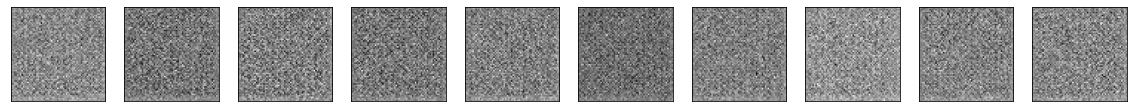

In [147]:
n = 10 # how many pictures to display
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(test_this[i].reshape(64, 64))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()